## 1.선형회귀 모델 훈련
훈련 방법에는 두 가지가 있다.
- 직접 계산할 수 있는 공식을 사용해서 훈련 세트에 가장 잘 맞는 모델 파라미터 즉, 훈련 세트에 대해 비용 함수를 최소화하는 모델 파라미터를 해석적으로 구한다.
- 경사 하강법을 사용해 모델 파라미터를 조금씩 바꾸며 비용함수를 훈련 세트에 대해 최소화시킨다. 

선형 회귀 모델은  $\hat{y} = \theta_0+\theta_1x_1+\theta_2x_2+\dots +\theta_nx_n$
- $\hat{y}$: 예측값
- n: 특성의 수
- $x_i$: i번째 특성값
- $\theta_j$: j번째 모델 파라미터

위 식을 벡터 형태로 쓰면
$\hat{y}=h_\theta(x)=\theta^T\cdot x$ 가 된다.

선형 모델을 훈련시킨다는 것은 모델이 훈련 세트에 잘 맞도록 모델 파라미터를 설정하는 것이다. 이를 위해 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정해야한다. 

훈련세트 X에 대한 가설$h_\theta$의 MSE는 아래와 같다. \
$MSE(X,h_\theta)=\frac{1}{m}\sum^m_{i=1}(\theta^Tx^{(i)}-y^{(i)})^2$

### 1-1.정규방정식
비용 함수를 최소화하는 $\theta$를 찾기 위한 해석적인 방법 즉, 바로 결과를 얻을 수 있는 수식을 **정규방정식(normal equation)** 이라고 한다. \
$ \hat\theta=(X^TX)^{-1}X^Ty $
- $\hat\theta$: 비용 함수를 최소화하는 $\theta$
- y: $y^{(1)} \text{~} y^{(m)}$ 까지 포함하는 타깃 벡터


공식 테스트 해보기

In [1]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

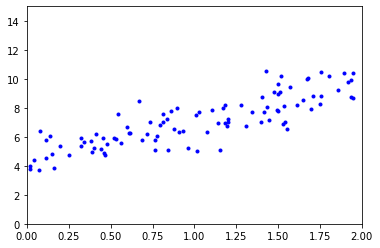

In [2]:
import matplotlib.pyplot as plt

plt.plot(X,y,'b.')
plt.axis([0,2,0,15])
plt.show()

이제 정규방정식을 이용해 $\hat\theta$값을 계산한다.

In [3]:
X_b = np.c_[np.ones((100,1)), X] # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # normal equation

In [4]:
theta_best

array([[4.44885008],
       [2.59975815]])

잡음 때문에 4,3인 원래 함수의 파라미터를 정확하게 재현하지 못했다.

$\hat\theta$를 사용해 예측

In [5]:
X_new =  np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.44885008],
       [9.64836639]])

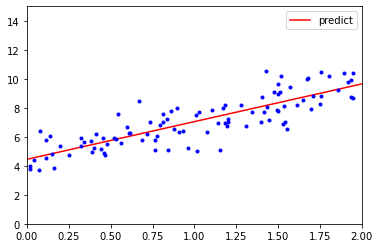

In [6]:
plt.plot(X_new, y_predict, 'r-', label='predict')
plt.plot(X, y, 'b.')
plt.axis([0,2,0,15])
plt.legend()
plt.show()

선형 회귀 수행

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [8]:
lin_reg.intercept_, lin_reg.coef_

(array([4.44885008]), array([[2.59975815]]))

In [9]:
lin_reg.predict(X_new)

array([[4.44885008],
       [9.64836639]])

LinearRegression class는 scipy.linalg.lstsq() 함수를 기반으로 한다.

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.44885008],
       [2.59975815]])

이 함수는 $ \hat\theta=X^+y $을 계산한다. $X^+$는 **유사역행렬(pseudoinverse)** 이다.  

np.linalg.pinv()함수를 이용해 유사역행렬을 구할 수 있다.

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.44885008],
       [2.59975815]])

유사역행렬 자체는 표준 행렬 분해 기법, **특잇값 분해(singular value decomposition, SVD)** 를 사용해 계산된다.SVD는 훈련 세트 행렬 X를 3개의 행렬 곱셈 $U\Sigma V^T$로 분해한다. 유사역행렬은 $X^+=V\Sigma^+U^T$로 계산된다. $\Sigma^+$를 계산하기 위해 시그마를 먼저 구하고, 낮은 임곘값보다 작은 수를 모두 0으로 바꾼다. 그 뒤 0이 아닌 수들을 역수로 치환한다. 마지막으로 만들어진 행렬을 전치한다. \
이는 정규방정식보다 효율적이며, 극단적인 경우도 처리할 수 있다.

### 1-2.계산 복잡도

정규방정식은 (n:특성수) (n+1)x(n+1) 크기가 되는 X^TX의 역행렬을 계산한다. 계산 복잡도는 일반적으로 $O(n^{2,4})$ ~ $O(n^3)$사이이다. \
LinearRegression클래스가 사용하는 SVD는 약 $O(n^2)$이다.

학습된 선형 회귀 모델을 예측이 매우 빠르다. 예측 계산 복잡도는 샘플 수와 특성 수에 선형적이다.

## 2.경사 하강법
'
경사 하강법의 기본 아이디어는 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정하는 것이다. 이는 파라미터 벡터 $\theta$에 대해 비용 함수의 현재 그래디언트를 계산하여 감소하는 방향으로 내려간다. 그래디언트가 0이 될 떄까지 반복한다. 

경사 하강법에서 중요한 파라미터는 스템의 크기로 학습률이라고 한다. 학습률이 작으면 조금씩 수렴하므로 오랜 반복을 해야한다. 반대로 너무 크다면 최소지점을 가로질러 올라갈 수도 있다.

경사하강법에는 전역 최솟값, 지역 최솟값이 있다. 만약 아래의 그림에서 왼쪽에서 시작했다면 전역 최솟값 대신 지역 최솟값에 수렵할 것이다.
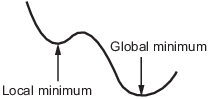

하지만 MSE비용 함수는 볼록 함수이므로 전역 최솟값만 존재한다. 또한 연속적이며, 기울기가 갑자기 변하지도 않는다. 

비용 함수는 특성들의 스케일이 매우 다르면 길쭉한 모양일 수 있다. 
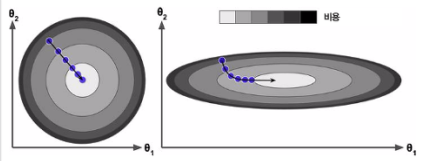

위의 그림에서 볼 수 있듯, 오른쪽그림은 수렴이 오래 걸린다. 값을 스케일링해야하는 이유가 된다. 

### 2-1.배치 경사 하강법

구현을 위해서는 각 모델 파라미터 $\theta_j$에 대해 비용 함수의 그레디언트를 계산해야 한다. 이를 **편도함수**라고 한다.

파라미터 $\theta_j$에 대한 비용함수의 편도함수는 $\frac{\partial}{\partial  \theta_j}\text{MSE}(\theta)=\frac{2}{m}\sum^m_i=1(\theta^Tx^{(i)}-y^{(i)})x^{(i)}_j $ \
편도함수 $\frac{\partial}{\partial  \theta_j}\text{MSE}(\theta)$는 비용 함수의 편도함수를 모두 담고있는 벡터 $\nabla_{\theta}\text{MSE}(\theta)$로 표현할 수도 있다.

이 공식은 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산한다. 그래서 이 알고리즘을 배치 경사 하강법이라고 한다. 매 스텝에서 훈련 데이터 전체를 사용하므로 훈련 세트가 크다면 느리다. 

위로 향하는 그레이디언트 벡터가 구해지면 아래로 가야하므로 $\theta$에서 $\nabla_{\theta}\text{MSE}(\theta)$를빼야 한다. 여기에서 스텝의 크기를 정하기 위해 학습률 $\gamma$가 사용된다.

경사 하강법의 스텝 \
$\theta^{(next step)} = \theta-\gamma \nabla_{\theta}\text{MSE}(\theta)$ 

위 알고리즘 구현

In [14]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * gradient

In [15]:
theta

array([[4.44885008],
       [2.59975815]])

학습률별로 스템 처음 10개

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

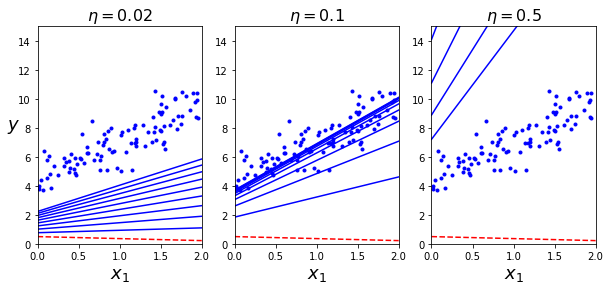

In [18]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

0.02는 너무 낮아 시간이 오래 걸릴 것이고, 0.1은 적절해 보인다. 0.5는 너무 커서 최적점에서 멀어지는 모습이다.

최적의 반복 횟수 지정을 위해 반복 횟수를 아주 크게 지정하고, 그레이디언트 벡터가 아주 작아지면, 즉 벡터의 노름이 어떤 값 $\varepsilon$(허용오차)보다 작아지면 거의 최솟값에 도달한 것이므로 알고리즘을 중지한다.

### 2-2. 확률적 경사 하강법

배치 경사하강법은 매 스텝마다 전체 훈련세트를 사용해 계산한다는 단점이 있었다. 이와 반대로 확률적 경사 하강법은 매 스텝마다 한 개의 샘플을 무작위로 정한 뒤 그 샘플에 대한 그레이디언트를 계산한다. 

이는 훨씬 빠르겠지만 불안정하다. 비용 함수가 최솟값에 가기까지 위아래로 요동치며 평균적으로 감소한다. 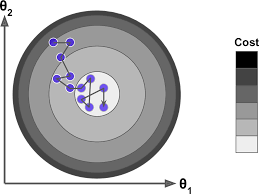 

무작위성은 지역 최솟값에서 탈출시켜주기도 하지만 전역 최솟값에 다다르지 못하게 하기도 한다. 이를 개선하기 위해 학습률을 점진적으로 감소시키는 방법 있다. 이때 매 반복의 학습률을 결정하는 함수를 학습 스케쥴이라고 부르며, 학습률이 너무 빨리 줄면 최솟값에 갇히거나, 가는 도중 멈춘다. 혹은 학습률이 너무 천천히 줄면 오래 걸리거나 지역 최솟값에 머물 수 있다.

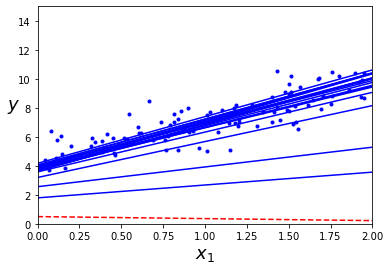

In [21]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                  
            y_predict = X_new_b.dot(theta)          
            style = "b-" if i > 0 else "r--"       
            plt.plot(X_new, y_predict, style)       
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                

plt.plot(X, y, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)          
plt.axis([0, 2, 0, 15])                             

plt.show()                                           

In [22]:
theta

array([[4.46186247],
       [2.60069372]])

sklearn에서 SGD 방식으로 선형 회귀를 사용하려면 SGDRegressor class를 사용한다.

다음 코드는 1000번의 epoch 동안 실행되며, 한 epoch에서 0.001보다 적게 손실이 줄 떄까지 반복한다.

In [24]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [26]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.46806568]), array([2.62533623]))

### 2-3. 미니배치 경사 하강법
미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산한다. 미니배치 경사 하강법의 장점은 행렬 연산에 최적화된 하드웨어(GPU)를 사용해서 얻는 성능 향상이다.

특히 미니배치를 크게 하면 파라미터 공간에서 SGD보다 덜 불규칙하게 움직인다. 결국 미니배치 경사 하강법이 최솟값에 더 가까이 도달하게 된다. 하지만 지역 최솟값에서 빠져나오기도 어렵다. 

In [31]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [32]:
theta

array([[4.34997205],
       [2.48824552]])

In [33]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)


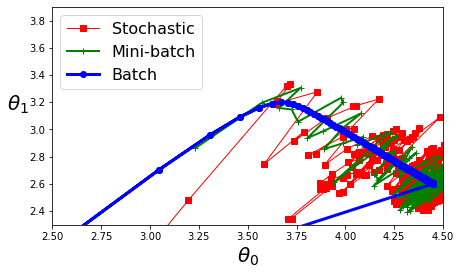

In [35]:

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])

plt.show()

위의 plot은 세 가지 경사 하강법 훈련 과정 동안 알고리즘이 파라미터 공간에서 움직인 경로이다. 모두 최솟값 근처엔 도달했지만 배치 경사 하강법은 근처에서 맴돌고 있다. 